In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io
import requests
from zipfile import ZipFile
from pathlib import Path
import calendar

f"Pandas version: {pd.__version__}"

'Pandas version: 2.2.3'

# Historical weather in Giessen (1950 - 2022)

## Introduction

In this exercise we will explore some weather data measurements for Giessen (state of Hessia) from 1950 to end of 2022. 

The data has been collected by Deutscher Wetterdienst and is publically available on https://opendata.dwd.de.

### Inspect the data source

Visit https://opendata.dwd.de and explore the available data.

### Download function

In [2]:
def download_and_extract(
    url: str, 
    output_path: Path = Path('tmp/dwd')
) -> None:
    """download DWD climate data from url and extract."""
    output_path.mkdir(exist_ok=True, parents=True)

    (ZipFile(io.BytesIO(requests.get(url).content))
     .extractall(path=output_path)
    )

### Download the data

*Data source: Deutscher Wetterdienst*


The function below will download are tarball containing the measurements as well as some metadata from a given URL. The tarball is extracted and placed in a specified directory.

In [3]:
# Download the data and extract.
URL = (
    'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/'
    'air_temperature/historical/stundenwerte_TU_01639_19500101_20231231_hist.zip'
)
TMP_DIRECTORY = Path("dwd") / "weather_giessen"

download_and_extract(url=URL, output_path=TMP_DIRECTORY)

# Import

## Task 1: Import the data

* Import the datafile `produkt_tu_stunde_19500101_20231231_01639.txt` from the download directory.
* Inspect the other data files?
    * Do they contain content that is relevant for handling the data?
* After having imported the data, in which format are the measurement dates given?

In [4]:
df = pd.read_csv(
    TMP_DIRECTORY / "produkt_tu_stunde_19500101_20231231_01639.txt", 
    sep=";",
    usecols=["MESS_DATUM", "TT_TU", "RF_TU"]
)

### Notes on measurement times

Refer to file `Metadaten_Parameter_tu_stunde_01639.html` for units and time zones for measurement date and time.

* Before 1996-10-01: MEZ time
* 1996-10-01 and later: UTC time

MEZ time is UTC time + 1h.

In [5]:
df.head()

MESS_DATUM  TT_TU  RF_TU
0  1950010101   -3.6   74.0
1  1950010102   -3.5   74.0
2  1950010103   -3.5   73.0
3  1950010104   -4.2   74.0
4  1950010105   -4.3   74.0

### What do we have here?

* Dates in the format (year)(month)(day)(time in 24 hour format).
    * Dates will be imported as `int64` type by Pandas.
    * Dates have to be converted to suitable date format.
        * Must take into account the different time zones to which the dates refer.
* Measurements
    * Temperature (in ${}^{\circ}\textrm{C}$)
    * Relative humidity (in %)

# Inspect and tweak

## Task 2: Column names, datetime format and index

Consider writing a function that solves the following tasks, e.g.

```python
def tweak_dataset(df: pd.DataFrame) -> pd.DataFrame:
    # your code goes here
```

* Rename the columns to have more explicit names.
* Convert the measurement dates and times to a suitable datetime format.
    * Make sure to have all datetimes refer to the UTC "timezone".
* Make the measurement date the index of the DataFrame.

Once you have completed the function you can call like so:

```python
df_tweaked = tweak_dataset(df) # df: The original dataframe\
```

### A slow way: Use string operations to convert all datetimes to UTC

In [6]:
def tweak_dataset1(df):
    return (
        df.rename(columns={
            "MESS_DATUM": "datetime",
            "TT_TU": "temperature",
            "RF_TU": "humidity"
        })
        .assign(
            time_offset=lambda df_: 
            (df_.datetime < 1996100100)
            .astype(str)
            .replace({"True": "+0100", "False": "+0000"}),
        )
        .assign(
            datetime=lambda df_: 
            pd.to_datetime(
                df_.datetime.astype(str) + df_.time_offset,
                format="%Y%m%d%H%z",
                utc=True
            )
        )
        .drop(
            columns=["time_offset",]
        )
        .set_index("datetime")
    )

### A faster way: Avoid string operations

In [7]:
def tweak_dataset2(df):
    def make_utc_datetime(df_):
        offsets = (df_["MESS_DATUM"] < 1996100100).astype(int)
        return (
            pd.to_datetime(df_["MESS_DATUM"], format="%Y%m%d%H") 
            - 
            pd.to_timedelta(offsets, unit="h")
        ).dt.tz_localize("UTC")
        
    return (
        df
        .assign(datetime=make_utc_datetime(df))
        .rename(columns={
            "TT_TU": "temperature",
            "RF_TU": "humidity"
        })
        .drop(columns=["MESS_DATUM"])
        .set_index("datetime")
    )


### Compare both variants

The runtime of tweaking the dataset as done above is mainly dominated by the conversion of datetimes before 1996-10-01 to UTC.

Running the following benchmark will take a while. On my current compute I am getting a speedup of ~7x in favour of the second variant.

In [8]:
# %timeit tweak_dataset1(df)
# %timeit tweak_dataset2(df)

In [9]:
df_tweaked1 = tweak_dataset1(df)

In [10]:
df_tweaked2 = tweak_dataset2(df)

In [11]:
np.all(df_tweaked1.index == df_tweaked2.index)

np.True_

### Actually tweak the dataset

In [12]:
df_tweaked = tweak_dataset2(df)

## Task 3: Data columns

### Task 3.1: Data types

What data types do we have?

In [13]:
df_tweaked.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 648547 entries, 1950-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  648547 non-null  float64
 1   humidity     648547 non-null  float64
dtypes: float64(2)
memory usage: 14.8 MB


The data types also determine the amount of memory consumed by the data set. How can you get this information?

In [14]:
df_tweaked.memory_usage(deep=True).sum() / 1024 ** 2 # express as MiB

np.float64(14.844062805175781)

In [15]:
df_tweaked.head()

temperature  humidity
datetime                                        
1950-01-01 00:00:00+00:00         -3.6      74.0
1950-01-01 01:00:00+00:00         -3.5      74.0
1950-01-01 02:00:00+00:00         -3.5      73.0
1950-01-01 03:00:00+00:00         -4.2      74.0
1950-01-01 04:00:00+00:00         -4.3      74.0

What is the range of values in the columns with measured data?

* The temperature values have to be stored as floating points values (currently float64)
* Can we represent the humidity values as int (maybe even unsigned?) values as well?

In [16]:
df_tweaked.describe()

temperature       humidity
count  648547.000000  648547.000000
mean        9.020892      76.513070
std        21.355300      36.871771
min      -999.000000    -999.000000
25%         3.500000      67.000000
50%         9.200000      82.000000
75%        15.000000      91.000000
max        38.000000     100.000000

Can you choose other datatypes for the numeric columns that consume *less* memory without losing information? 

* Test if a particular choice of datatype indeed keeps all the relevant information.

Let's see if there are floating points values contained in the humidity column!

In [17]:
np.abs(df_tweaked["humidity"].astype(int) - df_tweaked["humidity"]).sum()

np.float64(0.0)

The temperature column has floating points values with a fractional part. 

In [18]:
np.abs(df_tweaked["temperature"].astype(int) - df_tweaked["temperature"]).sum()

np.float64(277984.3000000001)

There are not floating points values present in the humidity column; hence we can convert to integers. 

But what integer type?

* Relative humidity can only by from $[0\%, 100\%]$.
    * No negative values allowed.
    * Values cannot be larger 100.
    * $\Rightarrow$ Can use an unsigned integer with only 1 byte (uint8)

### Task 3.2: Finding junk data

Are there any unreasonable data in the dataset?

* Use summary statistics as well as graphical methods to search for such kind of data.

In [19]:
df_tweaked.describe()

temperature       humidity
count  648547.000000  648547.000000
mean        9.020892      76.513070
std        21.355300      36.871771
min      -999.000000    -999.000000
25%         3.500000      67.000000
50%         9.200000      82.000000
75%        15.000000      91.000000
max        38.000000     100.000000

The smallest value in each of the measurement colums is -999. Mostly likely, this is not a coincidence but rather an indicator for an erroneous measurement.

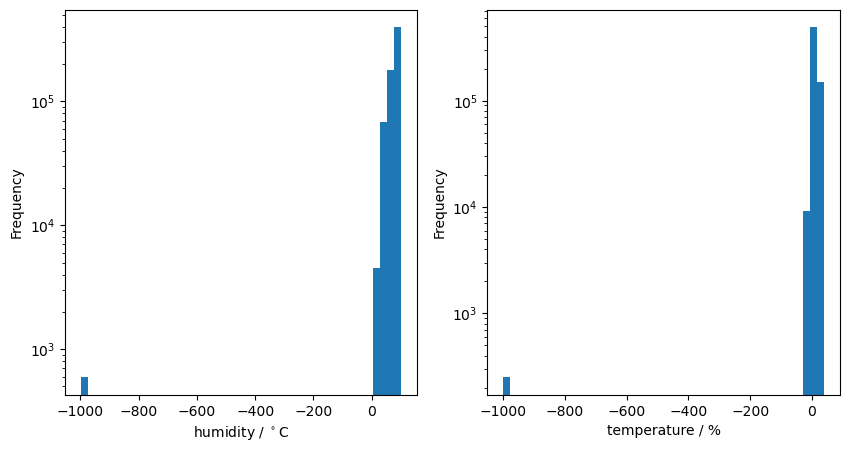

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for colname, units, ax in zip(df_tweaked.columns.difference(["datetime"]), (r"${}^\circ$C", "%"),  axes):
    ax.set_yscale("log")
    df_tweaked[colname].plot.hist(bins=46, ax=ax)
    ax.set_xlabel(f"{colname} / {units}")

The value at -999 seems to be the only value we actually want to get rid of.

* For the temperature column we cannot have values below absolute zero (-273.15 degree Celsius).
* For the relative humidity we cannot have negative values at all.

In [21]:
df_tweaked.loc[(df_tweaked["temperature"] < -273.15)]

temperature  humidity
datetime                                        
2012-02-20 15:00:00+00:00       -999.0    -999.0
2015-01-05 01:00:00+00:00       -999.0    -999.0
2015-01-05 03:00:00+00:00       -999.0    -999.0
2015-01-05 05:00:00+00:00       -999.0    -999.0
2015-01-05 06:00:00+00:00       -999.0    -999.0
...                                ...       ...
2023-09-15 11:00:00+00:00       -999.0    -999.0
2023-09-15 12:00:00+00:00       -999.0    -999.0
2023-10-19 09:00:00+00:00       -999.0    -999.0
2023-10-19 10:00:00+00:00       -999.0    -999.0
2023-10-19 11:00:00+00:00       -999.0    -999.0

[251 rows x 2 columns]

In [22]:
df_tweaked.loc[df_tweaked["humidity"] < 0]

temperature  humidity
datetime                                        
1995-08-06 23:00:00+00:00         19.3    -999.0
1998-06-25 17:00:00+00:00         18.3    -999.0
2000-09-06 07:00:00+00:00         10.1    -999.0
2012-02-20 15:00:00+00:00       -999.0    -999.0
2012-02-20 16:00:00+00:00          2.7    -999.0
...                                ...       ...
2023-09-15 11:00:00+00:00       -999.0    -999.0
2023-09-15 12:00:00+00:00       -999.0    -999.0
2023-10-19 09:00:00+00:00       -999.0    -999.0
2023-10-19 10:00:00+00:00       -999.0    -999.0
2023-10-19 11:00:00+00:00       -999.0    -999.0

[593 rows x 2 columns]

The are rows where both the temperature as well as the humidity have been set to -999. But there are also cases where the temperature measurement succeeded while that for the humidity did not.

In order to get rid of all these rows we replace -999 with NaNs and then remove the NaNs.


In [23]:
(df_tweaked
 .replace(-999.0, np.nan)
 .dropna()
 .describe()
)

temperature       humidity
count  647954.000000  647954.000000
mean        9.409861      77.497367
std         7.917280      17.354447
min       -20.900000       7.000000
25%         3.500000      67.000000
50%         9.200000      82.000000
75%        15.000000      91.000000
max        38.000000     100.000000

### Task 3.3: Some more tweaking

Further tweak the data based on the observations made above.

* Remove junk data
* Make type conversions if needed and possible

Again, consider wrapping the code used to clean the dataset further inside a function and call it on the previous version of the dataframe (that has to be cleaned further).

In [24]:
def tweak_dataset_further(df_):
    return (df_
    # Get rid of data from erroneous measurements
    .replace(-999, np.nan)
    .dropna()
    # Type conversion for the data columns
    .astype({
        "temperature": np.float32,
        "humidity": np.uint8,
    }))

In [25]:
df_tweaked = tweak_dataset_further(df_tweaked)

In [26]:
df_tweaked.head()

temperature  humidity
datetime                                        
1950-01-01 00:00:00+00:00         -3.6        74
1950-01-01 01:00:00+00:00         -3.5        74
1950-01-01 02:00:00+00:00         -3.5        73
1950-01-01 03:00:00+00:00         -4.2        74
1950-01-01 04:00:00+00:00         -4.3        74

# Visualisation

## Task 4: Make plots to further explore the data.

* Use the datetime index and suitable groupings / aggregations to analyse e.g. the temperature over time.
* Some ideas:
    * Compare the course of temperature for different decades
        * Remember that the data was recorded hourly! What can you do to make the plots look less noisy?
    * Compare the mean monthly temperature for several years.
    * Investigate the change in average monthly temperature relative to some reference year.
        * You might find one of [these plots](https://en.wikipedia.org/wiki/Climate_change_art) inspiring. 

### Helpful methods

* [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`resample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)
* [`rolling`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)

### Temperatures

Plot all temperature values available in the dataset

<Axes: xlabel='year', ylabel='temperature / degree Celsius'>

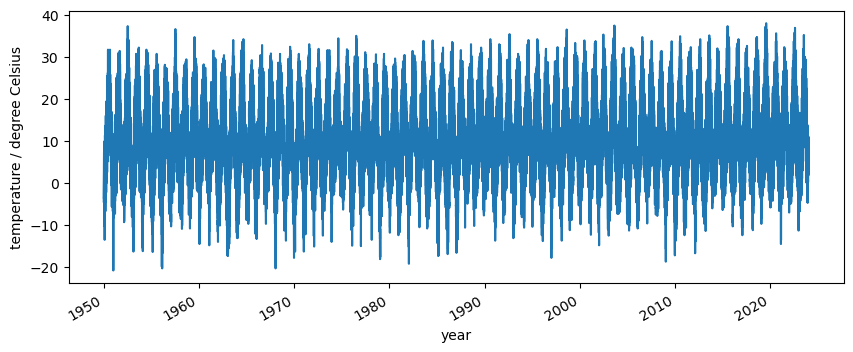

In [27]:
_, ax = plt.subplots(1, figsize=(10, 4))

(df_tweaked
 ["temperature"]
 .plot(ax=ax, xlabel="year", ylabel="temperature / degree Celsius")
)

Only plot slice from time interval. 

<Axes: xlabel='year', ylabel='temperature / deg Celsius'>

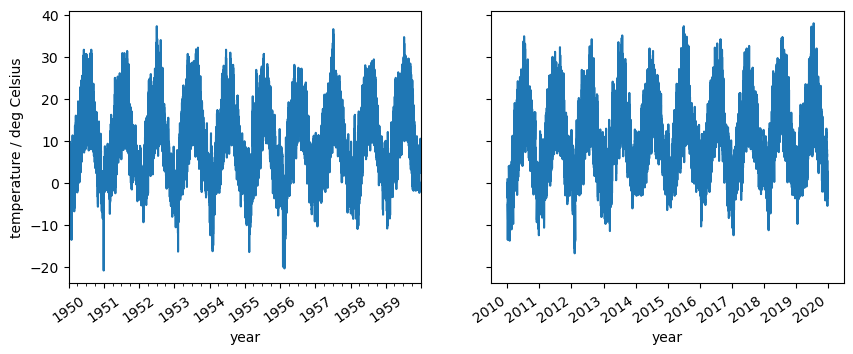

In [28]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

(df_tweaked
 .loc["1950-01-01":"1959-12-31", "temperature"]
 .plot(ax=ax1, xlabel="year", ylabel="temperature / deg Celsius", rot=35)
)

(df_tweaked
 .loc["2010-01-01":"2019-12-31", "temperature"]
 .plot(ax=ax2, xlabel="year", ylabel="temperature / deg Celsius", rot=35)
)

In order to smooth the curves we can apply a [resampling](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) of the curves and to compute for example the mean value of the temperatures in the sampling interval. When leveraging both the median and the mean value we can get an idea about the distribution of temperatures in the sampling interval.

When using monthly resampling that the `resample` method uses *the end* of each month as a datetime. You can explore this by executing 

```python
>>> (t_with_7resample
     .agg(["mean", "median"])
    )
```

after having executed the cell below.

/tmp/ipykernel_7627/2838736607.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M") # monthly buckets with measured values


<Axes: xlabel='year'>

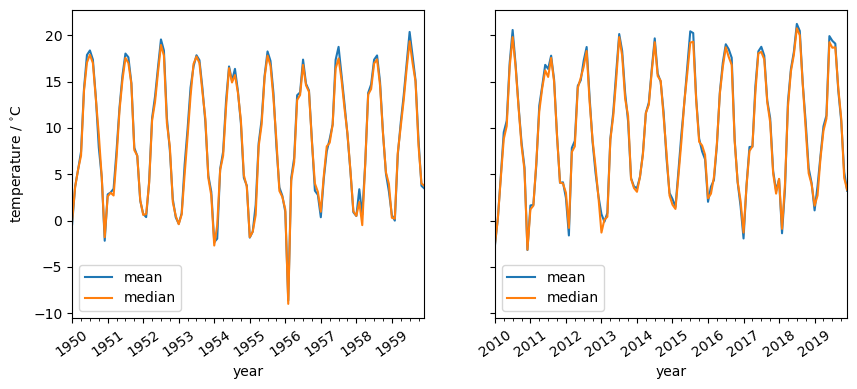

In [29]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

t_with_7resample = (
    df_tweaked
    ["temperature"]
    .resample("M") # monthly buckets with measured values
)

(t_with_7resample
 .agg(["mean", "median"])
 ["1950-01-01":"1959-12-31"]
 .plot(ax=ax1, rot=35, xlabel="year", ylabel=r"temperature / ${}^{\circ}$C")
)

(t_with_7resample
 .agg(["mean", "median"])
 ["2010-01-01":"2019-12-31"]
 .plot(ax=ax2, rot=35, xlabel="year")
)

Compare the average temperature per month for the beginning of each new decade.

/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipykernel_7627/895484561.py:7: FutureWarning: 'M' is deprecated and will be removed

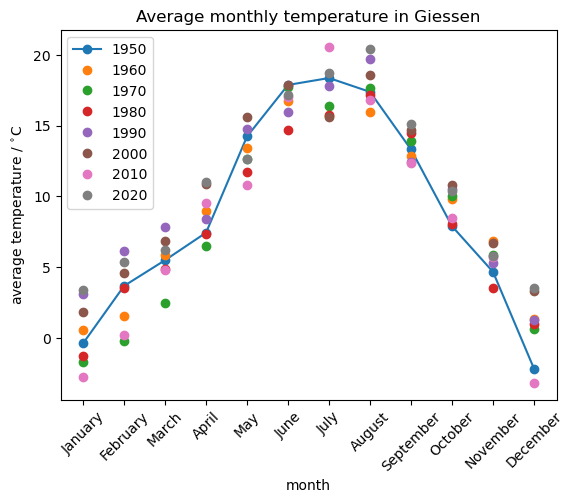

In [30]:
_, ax = plt.subplots(1)

def monthly_average_per_year(df, year):
    return (df
     .assign(month=lambda s: df_tweaked.index.month)
     .loc[f"{year}-01-01":f"{year}-12-31"]
     .resample("M")
     .mean()
     .set_index("month")
     ["temperature"]
    )

for year in (range(1950, 2021, 10)):
    (monthly_average_per_year(df_tweaked, year)
     .plot(ax=ax, xlabel="month", ylabel=r"average temperature / ${}^{\circ}$C", 
           linestyle="-" if year == 1950 else "", 
           marker="o", label=year)
    )

ax.set_xticks(range(1, 13))
ax.set_xticklabels([calendar.month_name[idx] for idx in range(1, 13)], rotation=45)
    
ax.set_title("Average monthly temperature in Giessen")
ax.legend()